In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import multiprocessing as mp
import numpy as np
from  utils.run_foraging_testbed import run_sessions_parallel, para_scan
from utils.foraging_testbed_models import BanditRestless, Bandit

n_worker = int(mp.cpu_count())  # Optimal number = number of physical cores
pool = mp.Pool(processes = n_worker)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


apply_async: 100%|██████████| 500/500 [00:04<00:00, 103.23it/s]
/root/capsule/utils/foraging_testbed_plots.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.nonzero(rewarded_trials)[0], 0.5 + (choice_history[0,rewarded_trials]-0.5) * 1.4,


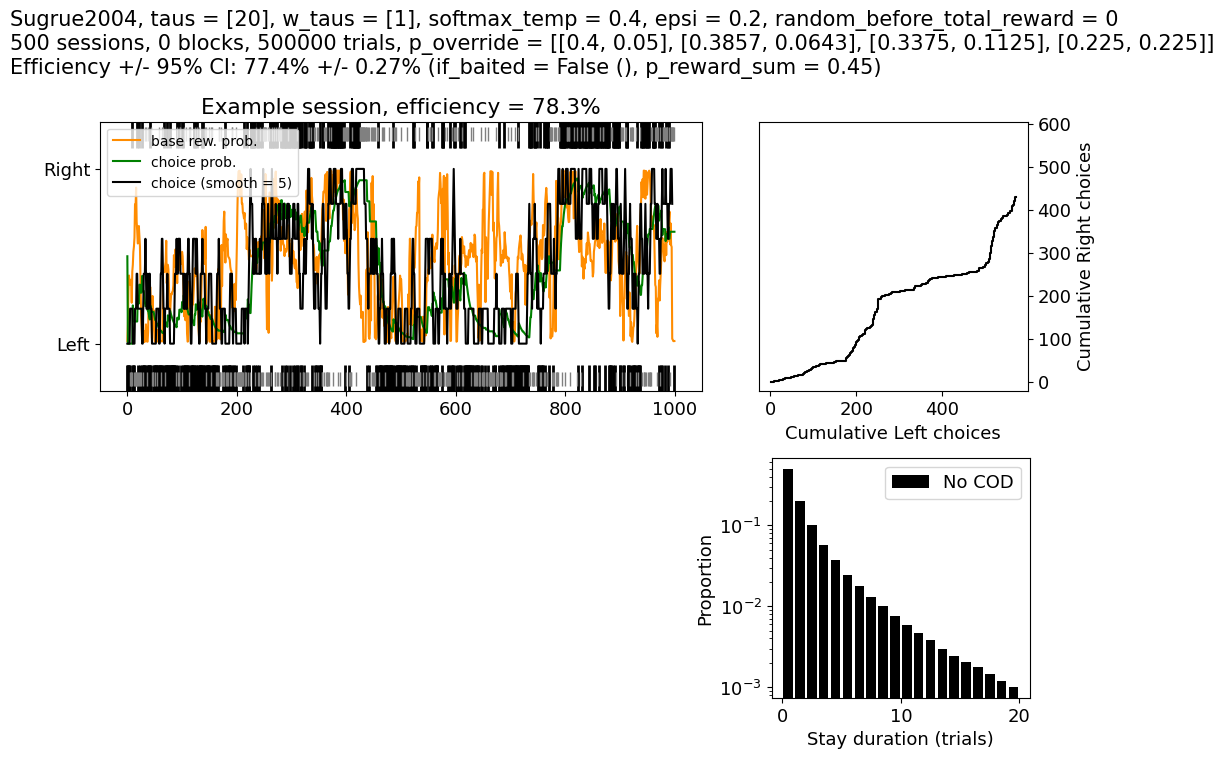

In [2]:
bandit = BanditRestless(forager='Sugrue2004',  epsilon = 0.2,  step_sizes = [0.2, 0.1], forget_rate = 0.05, softmax_temperature = 0.4, )
results_all_sessions = run_sessions_parallel(bandit, n_reps=500, pool=pool)

In [19]:
para_scan(forager='Sugrue2004', 
          task='Bandit_block',
          para_to_scan={'taus': np.power(2, np.linspace(0,5,20)), 
                         'epsilon': np.power(2, np.linspace(-4,0,20))}, 
          n_reps=50, pool=pool);

apply_async: 100%|██████████| 20000/20000 [01:32<00:00, 215.71it/s]


Restless bandit, `sigma = 0.15`

In [20]:
results_para_scan = para_scan(forager='Sugrue2004', 
                   task='Bandit_restless',
                   sigma=0.15,
                   para_to_scan={'taus': np.power(2, np.linspace(0,5,20)), 
                                'epsilon': np.power(2, np.linspace(-4,0,20))}, 
                   n_reps=50, pool=pool)

apply_async: 100%|██████████| 20000/20000 [01:23<00:00, 239.49it/s]


apply_async: 100%|██████████| 100/100 [00:00<00:00, 114.55it/s]


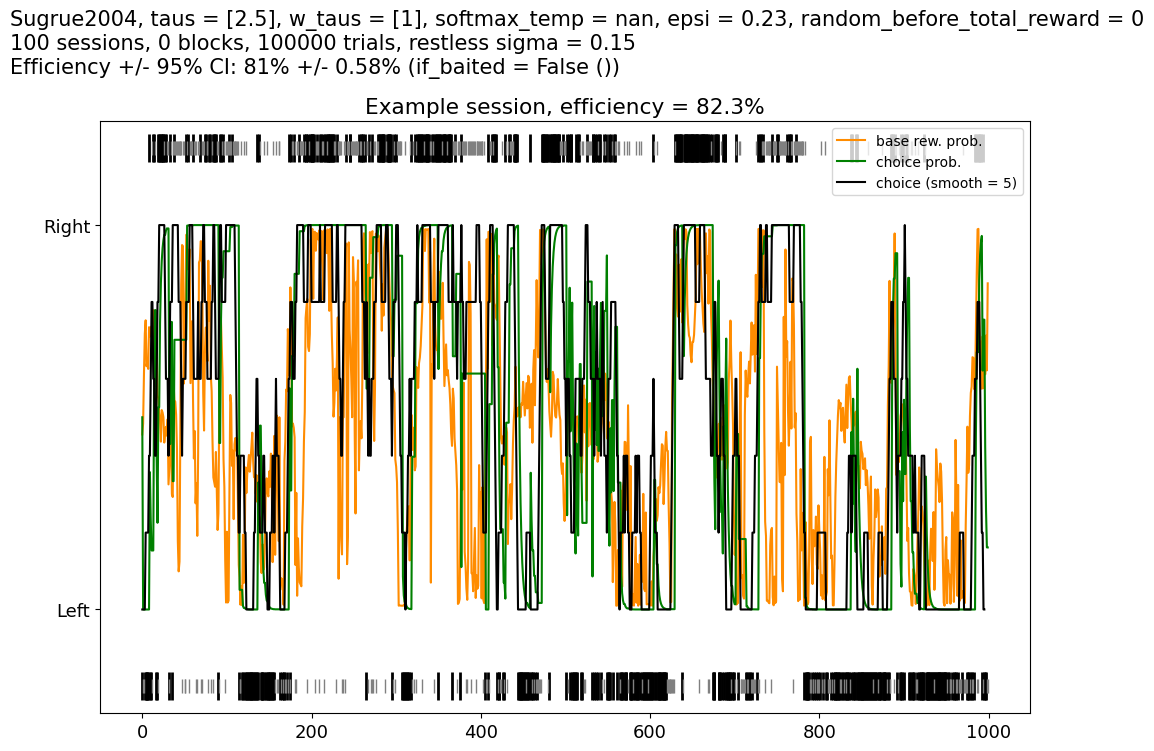

In [39]:
bandit = BanditRestless(forager='Sugrue2004',  
                        sigma=0.15,
                        epsilon=0.23,  
                        taus=2.5, )
results_all_sessions = run_sessions_parallel(bandit, n_reps=100, pool=pool)

Restless bandit, `sigma = 0.08`

In [36]:
results_para_scan = para_scan(forager='Sugrue2004', 
                   task='Bandit_restless',
                   sigma=0.08,
                   para_to_scan={'taus': np.power(2, np.linspace(0,5,20)), 
                                'epsilon': np.power(2, np.linspace(-4,0,20))}, 
                   n_reps=50, pool=pool)

apply_async: 100%|██████████| 20000/20000 [02:23<00:00, 139.34it/s]


apply_async: 100%|██████████| 100/100 [00:00<00:00, 119.43it/s]


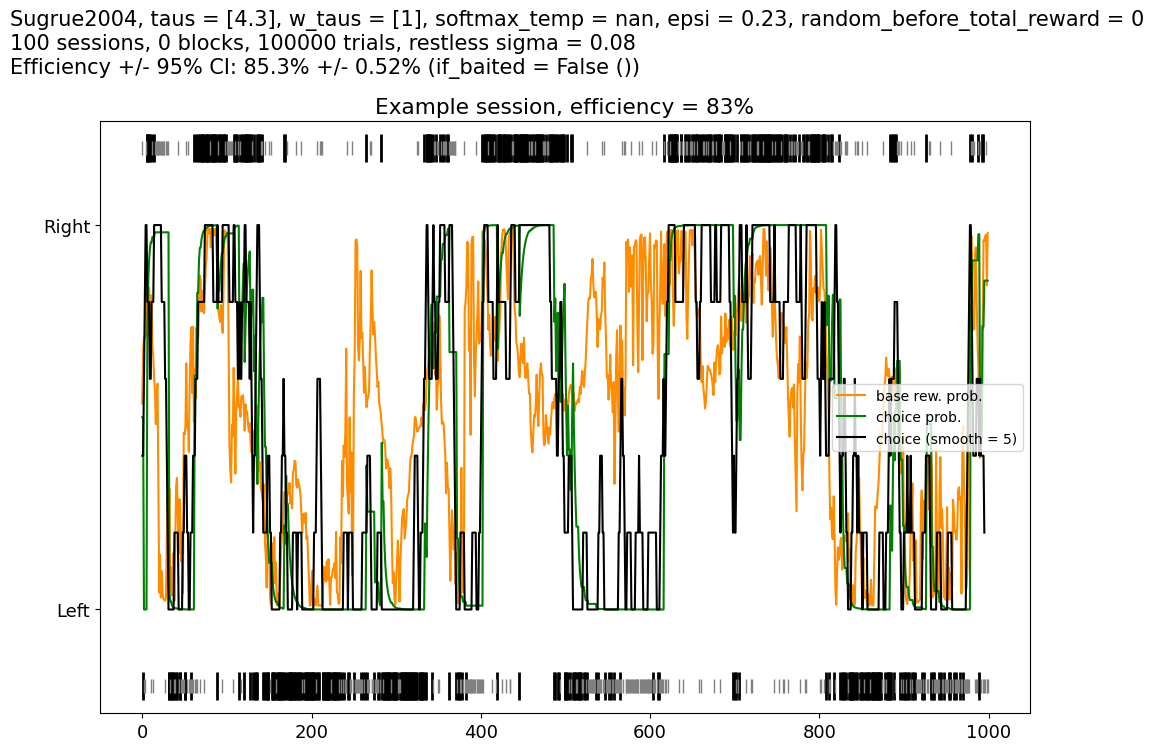

In [40]:
bandit = BanditRestless(forager='Sugrue2004', 
                        sigma=0.08, 
                        epsilon=0.23,  
                        taus=4.3, )
results_all_sessions = run_sessions_parallel(bandit, n_reps=100, pool=pool)

In [37]:
results_para_scan = para_scan(forager='Sugrue2004', 
                   task='Bandit_restless',
                   sigma=0.20,
                   para_to_scan={'taus': np.power(2, np.linspace(0,5,20)), 
                                'epsilon': np.power(2, np.linspace(-4,0,20))}, 
                   n_reps=50, pool=pool)

apply_async: 100%|██████████| 20000/20000 [02:24<00:00, 138.69it/s]


apply_async: 100%|██████████| 100/100 [00:00<00:00, 114.39it/s]


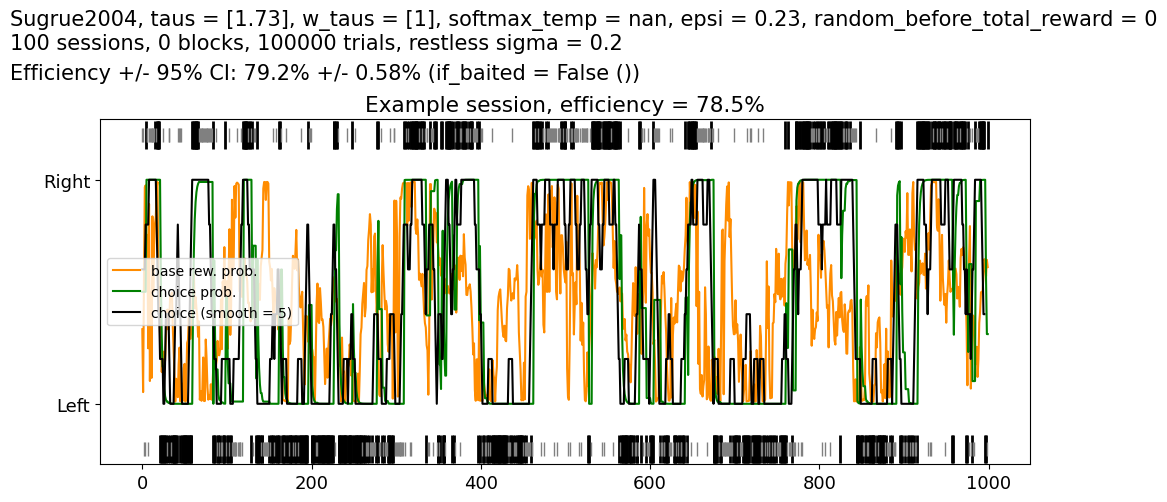

In [47]:
bandit = BanditRestless(forager='Sugrue2004', 
                        sigma=0.20, 
                        epsilon=0.23,  
                        taus=1.73, )
results_all_sessions = run_sessions_parallel(bandit, n_reps=100, pool=pool)